In [1]:
import os, sys
sys.path += [os.path.dirname('../scripts/')]

In [2]:
import pandas as pd
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
model_ckpt = 'CL_valaro_expression_alter_z64_bs512'

In [7]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('../outputs/' + model_ckpt + '/model')
model = ViTForImageClassification.from_pretrained('../outputs/' + model_ckpt + '/model').to(device)

In [8]:
from torchaffectnet import AffectNetDataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize,
])
valaro_dataset = AffectNetDataset('../../Affectnet/validation.csv',
                                  '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                                  transform=transform,
                                  mode='valence-arousal')
emotion_dataset = AffectNetDataset('../../Affectnet/validation.csv',
                                   '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                                   transform=transform,
                                   mode='classification')

ModuleNotFoundError: No module named 'torchaffectnet'

In [27]:
from tqdm import tqdm
import numpy as np

def CLS_tokens(model, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device),
                          output_hidden_states=True).hidden_states[-1][0, 0, :]
        tokens.append(token.cpu())
        labels.append(label)
    tokens, labels = torch.stack(tokens).squeeze(), torch.stack(labels)
    data = np.column_stack((tokens, labels))
    np.savetxt(os.path.join(f'data/{model_ckpt}'+"token_and_emotion.csv"), data, delimiter=',')
    return tokens, labels


In [28]:
from typing import Literal
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from umap.umap_ import UMAP
from sklearn.manifold import MDS

class MinMaxScaler():
    def __init__(self, min_, max_, input_min, input_max):
        self.min = min_
        self.max = max_
        self.in_min = input_min
        self.in_max = input_max
    
    def transform(self, input):
        return (input - self.in_min) / (self.in_max - self.in_min) * (self.max - self.min) + self.min

def plot_tokens_valaro(tokens, targets, n_neighbors, random_seed, method: Literal['umap', 'mds'] = 'umap'):
    if method == 'umap':
        compress = UMAP(n_neighbors=n_neighbors, random_state=random_seed)
    elif method == 'mds':
        compress = MDS(n_components=2, random_state=random_seed, n_init=2)
        tokens = F.normalize(tokens, dim=0)
    zs = np.array(compress.fit_transform(tokens.numpy()))
    data = np.column_stack((zs, targets.numpy()))
    np.savetxt(os.path.join(f'data/{model_ckpt}'+"valaro.csv"), data, delimiter=",")
    x = zs[:, 0]
    y = zs[:, 1]
    targets = targets.numpy()
    valence = targets[:, 0]
    arousal = targets[:, 1]
    scaler = MinMaxScaler(0.05, 0.9, -1, 1)
    alpha = scaler.transform(arousal)
    # alpha = (arousal - arousal.min()) / (arousal.max() - arousal.min())
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_box_aspect(1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1,1)

    mp = ax.scatter(x, y,
                    alpha=alpha,
                    c=valence,
                    cmap='turbo',
                    vmin=-1,
                    vmax=1,
                    s=5,
                    edgecolors=None)
    color_bar = fig.colorbar(mp, ax=ax)
    color_bar.set_label('valence')
    ax.scatter([],[], alpha=scaler.transform(np.array([-1])), c="black", label='arousal=-1.0', edgecolors=None)
    ax.scatter([],[], alpha=scaler.transform(np.array([-0.5])), c="black", label='arousal=-0.5', edgecolors=None)
    ax.scatter([],[], alpha=scaler.transform(np.array([0])), c="black", label='arousal=0.0', edgecolors=None)
    ax.scatter([],[], alpha=scaler.transform(np.array([0.5])), c="black", label='arousal=0.5', edgecolors=None)
    ax.scatter([],[], alpha=scaler.transform(np.array([1])), c="black", label='arousal=1.0', edgecolors=None)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1.3, 0.3))
    return fig, legend

In [29]:
import matplotlib.cm as cm

def plot_tokens_category(tokens, labels, n_neighbors, id2label, random_seed, method: Literal['umap', 'mds', 'csv'] = 'umap', csv_name: str = None):
    if method == 'umap':
        umap = UMAP(n_neighbors=n_neighbors, random_state=random_seed)
        zs = np.array(umap.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, labels.numpy()))
        np.savetxt(os.path.join(f'data/{model_ckpt}'+"emotion.csv"), data, delimiter=",")
        ys = labels.numpy()
    elif method == 'mds':
        mds = MDS(n_components=2, random_state=random_seed, n_init=2)
        tokens = F.normalize(tokens, dim=0)
        zs = np.array(mds.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, labels.numpy()))
        np.savetxt(os.path.join(f'data/{model_ckpt}'+"emotion.csv"), data, delimiter=",")
        ys = labels.numpy()
    elif method == 'csv':
        df = pd.read_csv(csv_name, header=None)
        cols = df.columns
        zs = df[cols[:2]].values
        ys = df[cols[2:]].values
        ys = ys.reshape((ys.shape[0]))
        print(ys)
    data = np.column_stack((zs, ys))
    # np.savetxt(os.path.join(f'data/{model_ckpt}'+"emotion.csv"), data, delimiter=",")
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    ax.set_box_aspect(1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1,1)

    label2point = {}
    print('plotting tokens...')
    for x, y in tqdm(zip(zs, ys)):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    # fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.5))
    legend = ax.legend(handles, labels, loc='upper left',
                       bbox_to_anchor=(1.2, 0.5))
    return fig, legend

In [30]:
# features, labels = CLS_tokens(model, valaro_dataset, device)
# fig, legend = plot_tokens_valaro(features, labels, 20, 0, 'mds')

In [31]:
# fig.savefig(os.path.join(
#                 f'results/{model_ckpt}'+'valaro'+'.svg'), bbox_inches='tight', bbox_extra_artists=[
#                     legend])
# fig.savefig(os.path.join(
#                 f'results/{model_ckpt}'+'valaro'+'.png'), bbox_inches='tight', bbox_extra_artists=[
#                     legend])

100%|██████████| 4000/4000 [02:14<00:00, 29.67it/s] 
/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/tmp/ipykernel_11518/3383549397.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


plotting tokens...


4000it [00:03, 1060.40it/s]


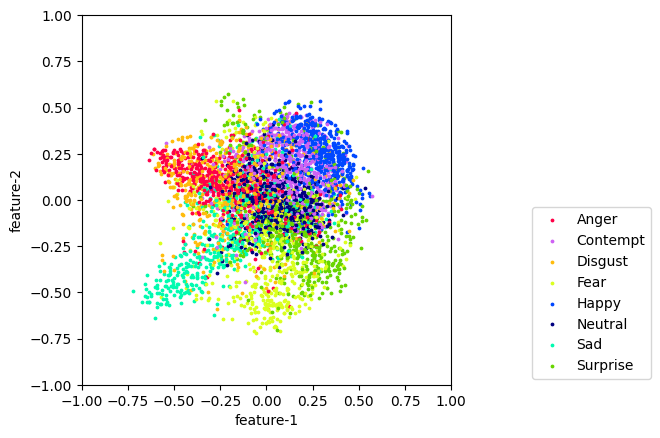

In [32]:
from utils import exclude_id

id2label, label2id = exclude_id([8,9,10])

features, labels = CLS_tokens(model, emotion_dataset, device)
fig, legend = plot_tokens_category(features, labels, 20, id2label, 0, 'mds', f'data/{model_ckpt}emotion.csv')

In [33]:
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'emotion'+'.svg'), bbox_inches='tight', bbox_extra_artists=[
                    legend])
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'emotion'+'.png'), bbox_inches='tight', bbox_extra_artists=[
                    legend])